### Import Libraries 

In [1]:
import pandas as pd 
from Standardization import metric_normalizer

from matplotlib import pyplot as plt 

from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report  # Import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

#formats
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


### Import Dataset

In [2]:
df = pd.read_csv('/home/clivence/base_jupyter/Datadump/Model_Data/GU_Model_Data_V1_16k')

# df.head(50)
# df.columns

### Data Cleaning

In [3]:
#Filter out negative values - evetually need to research why this is happening 
df  = df[(df['2D Low in Pips'] > 0) | (df['2D Low in Pips'] > 0)] 

df = df[df['Action'] == 'Ultimate Action']
df = df[df['Ticker'] == 'GBP/USD']

df.fillna(0, inplace=True)

#Standardize the dataset
df =  metric_normalizer(df)

#Set date to datetime 
df['Date'] = pd.to_datetime(df['Date'])

#Create Date Derived Features 
df['Trade_Week_Year'] = df['Date'].dt.isocalendar().week
df['Trade_Week_Month'] = (df['Date'].dt.day -1)//7+1
df['Trade_Day_Week'] = df['Date'].dt.weekday + 1

#Create a new feature to identify the status of the previous trade 
df['Previous_Trade_Status'] = df['2D Trade Status'].shift(fill_value=0)


### Data Preprocessing 

In [4]:
#Subset Selection
X= df[['open', 'high', 'low', 'close', 'volume','Trade_Week_Year','Trade_Week_Month','Trade_Day_Week',
       'Day','Month','25EMA', '50EMA', '75EMA','100EMA', '125EMA',
        'Trend Status', 'Spread','5075 Trend Status', '75100 Trend Status',
       '100125 Trend Status', 'Order Type', 
        '%K', '%D', 'k_group', 'ADX', 'ADXR', 'slowk','slowd','CDL2CROWS', 'CDL3BLACKCROWS',
        'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE',
        'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK',
        'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL',
        'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI',
        'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
        'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS',
        'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS',
        'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM',
        'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD',
        'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN',
        'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE',
        'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP',
        'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS',
        'candle_bullish_score','candle_bearish_score','Previous_Trade_Status']]
Y = df['2D Trade Status']


#Create a list of columns to encode 
cat_cols_to_encode = ['Order Type']
#Create a list of cols for ordinal encoding 
cat_cols_for_ordinal_encoding = ['Trend Status','5075 Trend Status', '75100 Trend Status',
                    '100125 Trend Status','k_group']

#Create a list of cols to scale 
num_cols_to_scale = ['volume']

# #View row, cols count
# df.shape ,  X.shape, Y.shape

 #Split the data into training and test set 
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=.204, random_state=42, stratify=X['Order Type'])

print(f"Training Set: {X_train.shape}\
        \nTest Set: {X_test.shape}")

Training Set: (384, 92)        
Test Set: (99, 92)


In [5]:
# Create Column Transformer with appropriate preprocessing for numerical and categorical data
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
            ('scaler', MinMaxScaler())]), num_cols_to_scale),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), cat_cols_to_encode),
        ('cat_ordinal', OrdinalEncoder(), cat_cols_for_ordinal_encoding)
    ],
    remainder='passthrough')

Preprocessor.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['volume']),
                                ('cat_onehot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Order Type']),
                                ('cat_ordinal', OrdinalEncoder(),
                                 ['Trend Status', '5075 Trend Status',
                                  '75100 Trend Status', '100125 Trend Status',
                                  'k_group'])])

In [6]:
# X_train_transform = Preprocessor.fit_transform(X_train)

# X_train_transform

#Use mutual information for feature selection default set at 100
Selection = SelectPercentile(mutual_info_classif, percentile=100)

In [7]:
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, f1_score, precision_score, recall_score

In [8]:
def enhanced_metrics( predictions,test=y_test):
    '''This function calculates and returns various evaluation metrics based on predicted values and true labels.
    Returns:
- output: str
  A string containing the calculated evaluation metrics.

Metrics included:
- Accuracy: The proportion of correctly classified samples.
- F1 Score: The harmonic mean of precision and recall, indicating overall model performance.
- Recall: The proportion of true positive samples correctly classified.
- Precision: The proportion of predicted positive samples that are actually positive.
    
'''
    Accuracy = accuracy_score(test, predictions)
    f_score = f1_score(test, predictions)
    recall_ = recall_score(test, predictions)
    precision = precision_score(test, predictions)
    Out_put = f"Accuracy: {(Accuracy.round(decimals=3))*100}\n" + \
            f"F1 Score: {(f_score.round(decimals=3))*100}\n" + \
            f"Recall: {(recall_.round(decimals=3))*100}\n" + \
            f"Precision: {(precision.round(decimals=3))*100}" 
    return Out_put

### Base Models with No Parameter

In [20]:
#Create PiPeline to be used in Model
Base_LR_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('Feature_Selection', Selection),
    ('RF_Model',LogisticRegression())])

#Fit the training data 
Base_LR_Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
Base_LR_Model_Predictions = Base_LR_Model_Pipeline.predict(X_test)

#Store individual metrics in a variable for later use 
LR_Accuracy = (accuracy_score(y_test, Base_LR_Model_Predictions))*100
LR_f_score = (f1_score(y_test, Base_LR_Model_Predictions))*100
LR_recall_ = (recall_score(y_test, Base_LR_Model_Predictions))*100
LR_precision = (precision_score(y_test, Base_LR_Model_Predictions))*100

#Get Error Metrics of Random Forest Model
LR_Model_Metrics = enhanced_metrics(y_test, Base_LR_Model_Predictions)

#View Error Metric 
print(LR_Model_Metrics)

Accuracy: 64.60000000000001
F1 Score: 77.10000000000001
Recall: 75.6
Precision: 78.7


/home/clivence/base_jupyter/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier



#Create Pipeline to be used in SVC Model
Base_SVC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('Feature_Selection', Selection),
    ('SVC_Model',SVC())])

#Fit the training data 
Base_SVC_Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
Base_SVC_Model_Predictions = Base_SVC_Model_Pipeline.predict(X_test)

#Store individual metrics in a variable for later use 
SVC_Accuracy = (accuracy_score(y_test, Base_SVC_Model_Predictions))*100
SVC_f_score = (f1_score(y_test, Base_SVC_Model_Predictions))*100
SVC_recall_ = (recall_score(y_test, Base_SVC_Model_Predictions))*100
SVC_precision = (precision_score(y_test, Base_SVC_Model_Predictions))*100

#Get Error Metrics of SVC Model
SVC_Model_Metrics = enhanced_metrics(y_test, Base_SVC_Model_Predictions)

#View Error Metric 
print(SVC_Model_Metrics)

Accuracy: 75.8
F1 Score: 86.2
Recall: 75.8
Precision: 100.0


In [11]:
#Create Pipeline to be used in Descision Tree Model
Base_DT_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('Feature_Selection', Selection),
    ('DT_Model',DecisionTreeClassifier())])

#Fit the training data 
Base_DT_Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
Base_DT_Model_Predictions = Base_DT_Model_Pipeline.predict(X_test)

#Store individual metrics in a variable for later use 
DT_Accuracy = (accuracy_score(y_test, Base_DT_Model_Predictions))*100
DT_f_score = (f1_score(y_test, Base_DT_Model_Predictions))*100
DT_recall_ = (recall_score(y_test, Base_DT_Model_Predictions))*100
DT_precision = (precision_score(y_test, Base_DT_Model_Predictions))*100

#Get Error Metrics of Random Forest Model
DT_Model_Metrics = enhanced_metrics(y_test, Base_DT_Model_Predictions)

#View Error Metric 
print(DT_Model_Metrics)

Accuracy: 58.599999999999994
F1 Score: 70.89999999999999
Recall: 75.8
Precision: 66.7


In [12]:
# Create Model Pipeline
Base_RF_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('Feature_Selection', Selection),
    ('RF_Model', RandomForestClassifier(random_state=42))  
])

# Fit the training data
Base_RF_Model_Pipeline.fit(X_train, y_train)

# Make Predictions on the test set
Base_RF_Model_Predictions = Base_RF_Model_Pipeline.predict(X_test)

#Store individual metrics in a variable for later use 
RF_Accuracy = (accuracy_score(y_test, Base_RF_Model_Predictions))*100
RF_f_score = (f1_score(y_test, Base_RF_Model_Predictions))*100
RF_recall_ = (recall_score(y_test, Base_RF_Model_Predictions))*100
RF_precision = (precision_score(y_test, Base_RF_Model_Predictions))*100

# Use function 'enhanced_metrics' to evaluate model performance
RF_Model_Metrics = enhanced_metrics(y_test, Base_RF_Model_Predictions)

# View Error Metrics
print(RF_Model_Metrics)


Accuracy: 77.8
F1 Score: 86.4
Recall: 80.5
Precision: 93.30000000000001


In [25]:
#Create Pipeline to be used in Gradient Boosting Classfier Model
Base_GBC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('RF_Model',GradientBoostingClassifier())])

#Fit the training data 
Base_GBC_Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
Base_GBC_Model_Predictions = Base_GBC_Model_Pipeline.predict(X_test)

#Store individual metrics in a variable for later use 
GBC_Accuracy = (accuracy_score(y_test, Base_GBC_Model_Predictions))*100
GBC_f_score = (f1_score(y_test, Base_GBC_Model_Predictions))*100
GBC_recall_ = (recall_score(y_test, Base_GBC_Model_Predictions))*100
GBC_precision = (precision_score(y_test, Base_GBC_Model_Predictions))*100

#Get Error Metrics of Random Forest Model
GBC_Model_Metrics = enhanced_metrics(y_test, Base_GBC_Model_Predictions)

#View Error Metric 
print(GBC_Model_Metrics)

Accuracy: 72.7
F1 Score: 83.0
Recall: 78.60000000000001
Precision: 88.0


In [24]:
#Create PiPeline to be used in Model
Base_ADAC_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('RF_Model',AdaBoostClassifier())])

#Fit the training data 
Base_ADAC_Model_Pipeline.fit(X_train, y_train)

#Make Predictions on the test set 
Base_ADAC_Model_Predictions = Base_ADAC_Model_Pipeline.predict(X_test)

#Store individual metrics in a variable for later use 
ADAC_Accuracy = (accuracy_score(y_test, Base_ADAC_Model_Predictions))*100
ADAC_f_score = (f1_score(y_test, Base_ADAC_Model_Predictions))*100
ADAC_recall_ = (recall_score(y_test, Base_ADAC_Model_Predictions))*100
ADAC_precision = (precision_score(y_test, Base_ADAC_Model_Predictions))*100


#Get Error Metrics of Random Forest Model
ADAC_Model_Metrics = enhanced_metrics(y_test, Base_ADAC_Model_Predictions)

#View Error Metric 
print(ADAC_Model_Metrics)

Accuracy: 70.7
F1 Score: 80.80000000000001
Recall: 80.30000000000001
Precision: 81.3


### Base Model Summary 

In [15]:
#Create a dataframe to score metric scores
Classifier_Scores = pd.DataFrame()

In [21]:
# Create a DataFrame to store these values
metrics_df = pd.DataFrame({
    'Logistic Regression': [LR_Accuracy, LR_f_score, LR_recall_, LR_precision],
    'Descision Tree' : [DT_Accuracy, DT_f_score, DT_recall_, DT_precision],
    'Support Vector Machine' : [SVC_Accuracy, SVC_f_score, SVC_recall_, SVC_precision],
    'Random Forest' : [RF_Accuracy, RF_f_score, RF_recall_, RF_precision],
    'Gradient Boosting' : [GBC_Accuracy, GBC_f_score, GBC_recall_, GBC_precision],
    'ADA Boost ' : [ADAC_Accuracy, ADAC_f_score, ADAC_recall_, ADAC_precision],
}, index=['Accuracy','F1 Score', 'Recall', 'Precision'])

# Transpose the DataFrame 
metrics_df = metrics_df.transpose()

#rename the index 
metrics_df.index.name='Model Name'

metrics_df.reset_index(inplace=True)

# # Display the DataFrame
print(metrics_df)

               Model Name   Accuracy   F1 Score      Recall  Precision
0     Logistic Regression  64.646465  77.124183   78.666667  75.641026
1          Descision Tree  58.585859  70.921986   66.666667  75.757576
2  Support Vector Machine  75.757576  86.206897  100.000000  75.757576
3           Random Forest  77.777778  86.419753   93.333333  80.459770
4       Gradient Boosting  72.727273  83.018868   88.000000  78.571429
5              ADA Boost   70.707071  80.794702   81.333333  80.263158


/tmp/ipykernel_4157/378985640.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(accuracy_sorted_df['Model Name'], rotation=45)
/tmp/ipykernel_4157/378985640.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(precision_sorted_df['Model Name'], rotation=45)
/tmp/ipykernel_4157/378985640.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(recall_sorted_df['Model Name'], rotation=45)
/tmp/ipykernel_4157/378985640.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(f1_sorted_df['Model Name'], rotation=45)


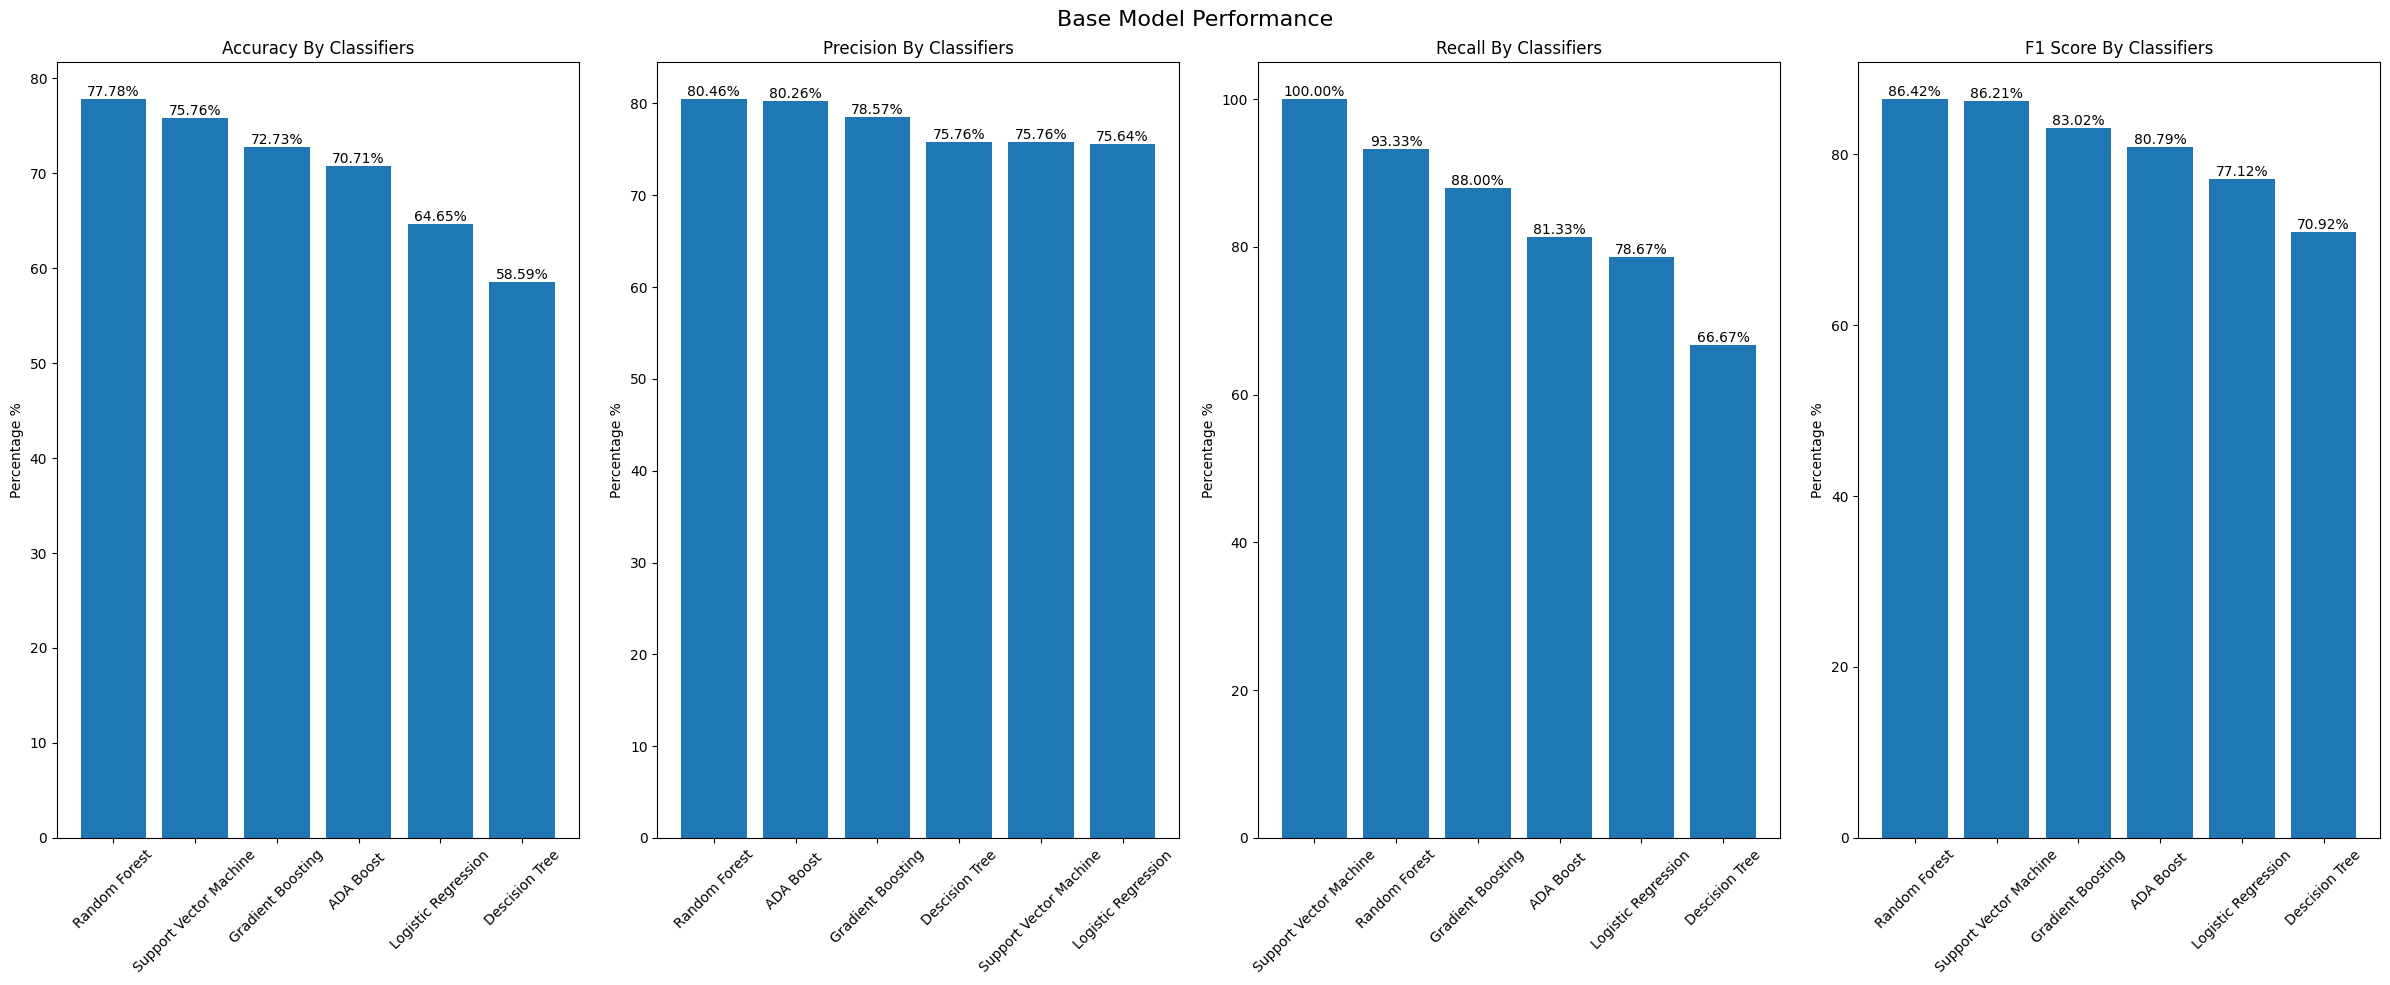

In [23]:
#Sort the df based on each metric 
accuracy_sorted_df = metrics_df.sort_values('Accuracy',ascending=False)
f1_sorted_df = metrics_df.sort_values('F1 Score',ascending=False)
recall_sorted_df = metrics_df.sort_values('Recall',ascending=False)
precision_sorted_df = metrics_df.sort_values('Precision',ascending=False)

#Create Figure 
fig, axs= plt.subplots(1,4, figsize=(24,10))

fig.suptitle("Base Model Performance",fontsize=16)

#Plot Accuracy in AXS[0,0]
bar_accuracy = axs[0].bar(accuracy_sorted_df['Model Name'], accuracy_sorted_df['Accuracy'])
axs[0].set_title('Accuracy By Classifiers')
axs[0].set_ylabel('Percentage %')
axs[0].set_xticklabels(accuracy_sorted_df['Model Name'], rotation=45)
for bar in bar_accuracy:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

#Plot Precision in AXS[1[]
bar_precision = axs[1].bar(precision_sorted_df['Model Name'], precision_sorted_df['Precision'])
axs[1].set_title('Precision By Classifiers')
axs[1].set_ylabel('Percentage %')
axs[1].set_xticklabels(precision_sorted_df['Model Name'], rotation=45)
for bar in bar_precision:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

#Plot Recall in AXS[2]
bar_recall = axs[2].bar(recall_sorted_df['Model Name'], recall_sorted_df['Recall'])
axs[2].set_title('Recall By Classifiers')
axs[2].set_ylabel('Percentage %')
axs[2].set_xticklabels(recall_sorted_df['Model Name'], rotation=45)
for bar in bar_recall:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
    
#Plot F1 Score in AXS[3]
bar_fscore = axs[3].bar(f1_sorted_df['Model Name'], f1_sorted_df['F1 Score'])
axs[3].set_title('F1 Score By Classifiers')
axs[3].set_ylabel('Percentage %')
axs[3].set_xticklabels(f1_sorted_df['Model Name'], rotation=45)
for bar in bar_fscore:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
    
plt.tight_layout()


### There might be an issue between the Recall and Precision value of Logistic Regression - do not delete this until investigate further 

### Feature Importance

In [18]:
#Retrived the Feature Selection Step 
feature_selection = Base_RF_Model_Pipeline.named_steps['Feature_Selection']

#Retrieve the trained model 
trained_RF_Model = Base_RF_Model_Pipeline.named_steps['RF_Model']

feature_importances = trained_RF_Model.feature_importances_

# Get the indices of selected features
selected_feature_indices = feature_selection.get_support(indices=True)

# Extract feature names
all_feature_names = Preprocessor.get_feature_names_out()
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

# Combine feature names with their importances
features_and_importances = zip(selected_feature_names, feature_importances)

# Sort features by importance
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)


# Create a DataFrame from the features and importances
feature_importance_df = pd.DataFrame(sorted_features_and_importances, columns=['Feature', 'Importance'])

# Display the DataFrame
feature_importance_df.head(20)

,Feature,Importance
0,num__volume,0.059827
1,remainder__Spread,0.051581
2,remainder__%D,0.048857
3,remainder__%K,0.047307
4,remainder__Day,0.047281
5,remainder__slowk,0.046831
6,remainder__ADXR,0.046302
7,remainder__ADX,0.044878
8,remainder__slowd,0.044316
9,remainder__high,0.038249


### Reference: Concepts To Understand 

#### Accuracy: 
                - Measures the overall correctness of the classifier. It's calculated by dividing the number of correctly classifier samples by the total number of samples. 
                - Accuracy tells us how often the classifier correctly predicted whether a trade is a successful or not compared to the total number of trades.
                - An Accuracy of .76 means that classifier correctly predicted the trade status for approximately 76% of the time. 
                
#### Recall:
             - Also known as sensitivity or true positive, measures  the ability of the classifier to correctly identify all positive instances. 
             - In the context of a trade status classifier, recall tells us how often the classifier correctly identified out of all successful trades.
             - A recall of approximately .795 means that the classifier correctly identified 79.5% of the successful trades. 
#### Precision 
              - Measures the ability of the classifier to correctly identify only relevant instances among all instances it has classified as positive. 
              - In the context of a trade status classifier, precision measures the proportion of correctly predicted successful trades out of all successful trades.
              - A precision of approximately .933 means that about 93.3% of the trades predicted as successful by the classifier were actually successful. 
#### F1 Score
                - Is a metric that combines precision and recall into a single value - it is the harmonic mean between precision and recall. 
                - Precision measures the proportion of correctly predicted positive cases among all predicted cases.
                - While Recall, measures the proportion of correctly predicted positive cases among all actual positive cases.
                - F1 Score provides a balance between precision and recall, it is especially useful when there is an uneven class distribution.
                - In the context of a trade status classifier, an F1 Score of .859 indicate a good balance between precision and recall predicting whether trades were successful or not. 